<a href="https://colab.research.google.com/github/antonysama/Projects_w._time_series/blob/master/DUCs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
install.packages(c('dplyr', 'magrittr','skimr','tidyr','janitor','datetime','readxl','forecast', dependencies = TRUE, repos = "https://cran.rstudio.com/"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“packages ‘TRUE’, ‘https://cran.rstudio.com/’ are not available for this version of R

Versions of these packages for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”


In [64]:
x<-c('dplyr', 'magrittr','skimr','tidyr','janitor','datetime','readxl', 'forecast','ggplot2')
lapply(x, require, character.only = TRUE)

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

In [65]:
data <- read_excel("AER.xlsx", range = "A1:j174")

In [66]:
head(data)  # View the first few rows of the data

Drill_Year,Drill_month,Drilled well,Drilled well and Completed,Crude_bitumen_well_count,Oil_well_count,Gas_well_count,Other_well_count,Connected,Not Connected
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2009,1,1660,460,23,10,262,165,295,165
2009,2,1600,1079,43,20,754,262,817,262
2009,3,490,437,37,18,169,213,224,213
2009,4,113,90,35,3,18,34,56,34
2009,5,137,130,40,6,29,55,75,55
2009,6,337,238,24,10,80,124,114,124


In [79]:
# Combine first and second columns and create a date column
data$date <- as.Date(paste(data$Drill_Year, data$Drill_month, "01", sep = "-"), format = "%Y-%m-%d")
# Create the DUC% field
data$DUC_percent <- (1 - (data$`Drilled well and Completed` / data$`Drilled well`)) * 100
# View the updated data
tail(data)

Drill_Year,Drill_month,Drilled well,Drilled well and Completed,Crude_bitumen_well_count,Oil_well_count,Gas_well_count,Other_well_count,Connected,Not Connected,date,DUC_percent
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<dbl>
2022,12,617,590,46,98,65,381,209,381,2022-12-01,4.376013
2023,1,976,461,46,61,33,321,140,321,2023-01-01,52.766393
2023,2,958,649,51,124,72,402,247,402,2023-02-01,32.254697
2023,3,781,617,46,125,60,386,231,386,2023-03-01,20.998720
2023,4,383,344,37,26,43,238,106,238,2023-04-01,10.182768
2023,5,292,265,15,25,5,220,45,220,2023-05-01,9.246575


`geom_smooth()` using formula = 'y ~ x'


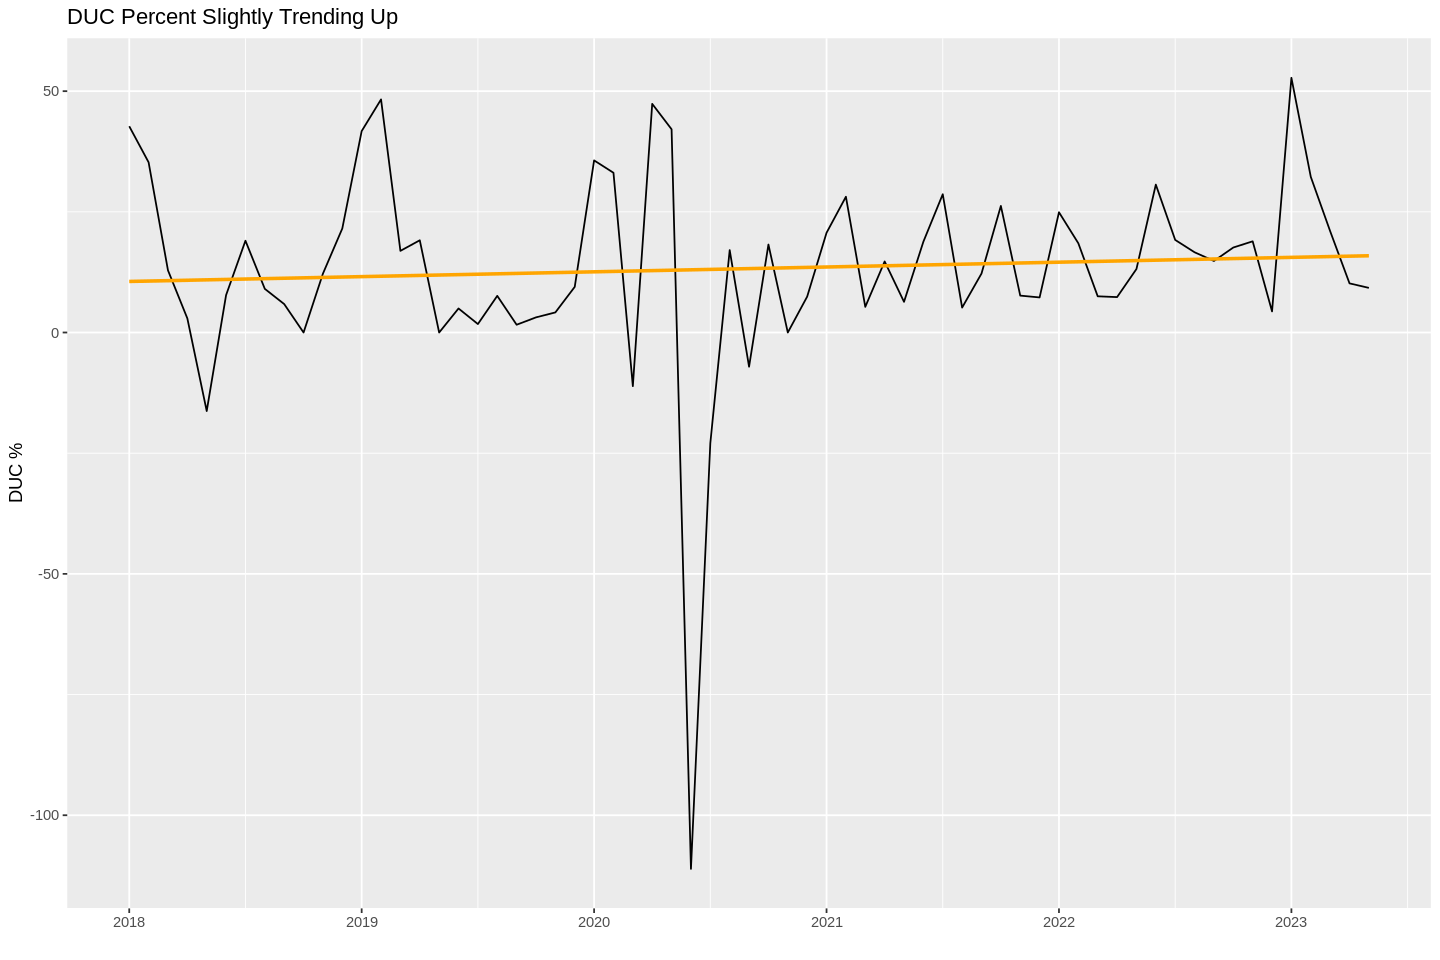

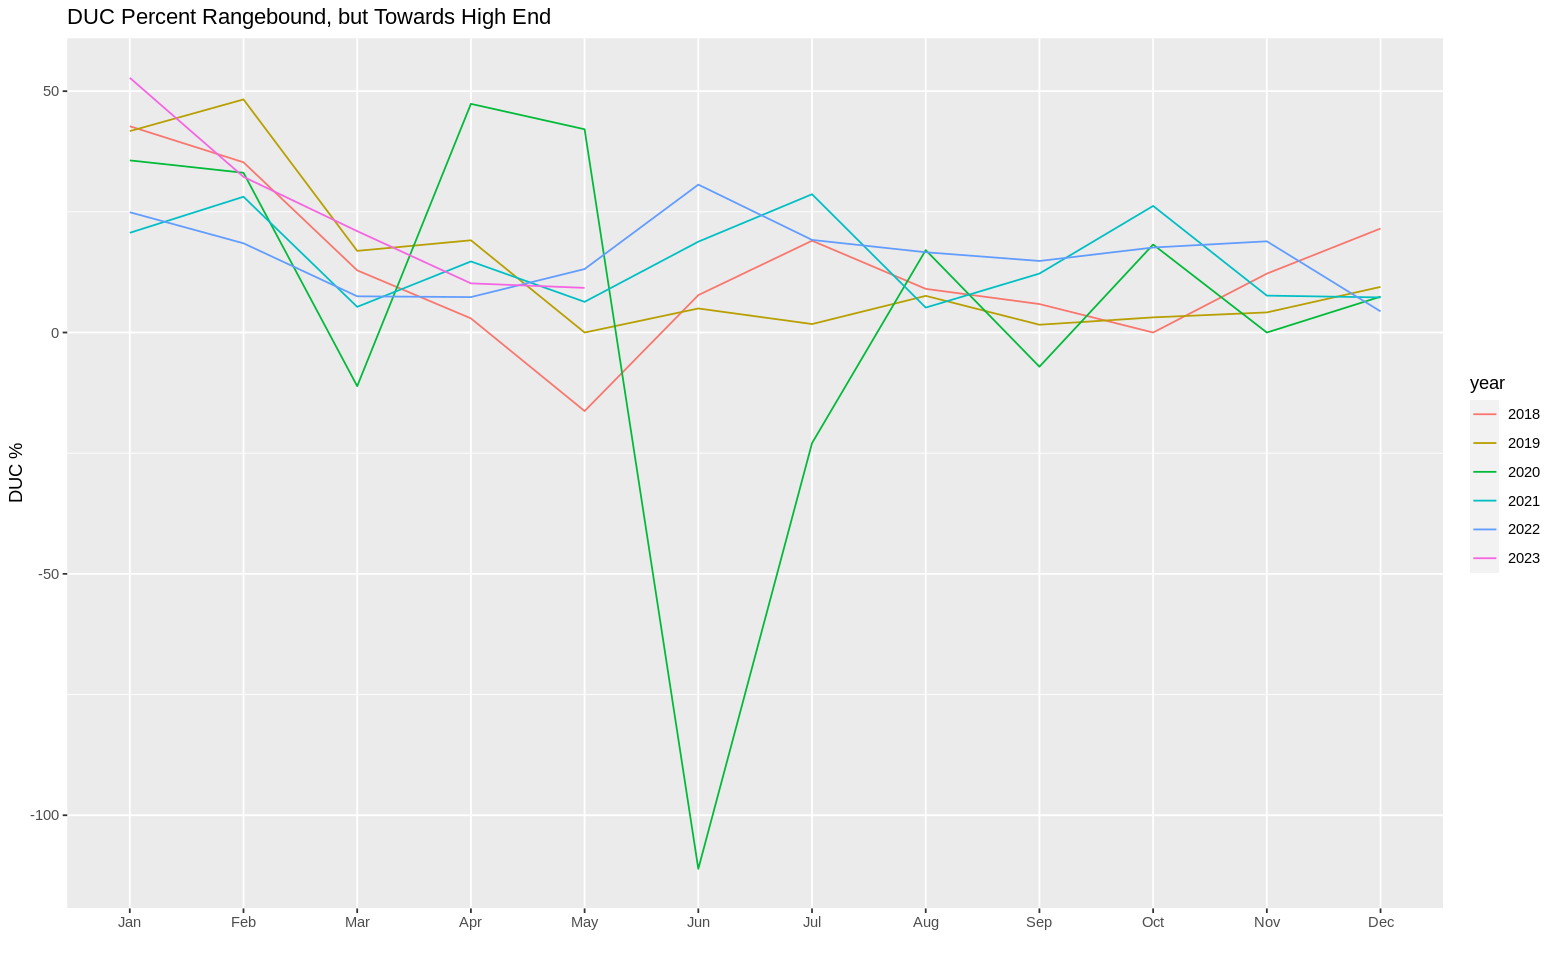

In [71]:
# Creating a time series and plotting seasonality
# Convert the 'date' column to a Date format (if not already done)
data$date <- as.Date(data$date)

# Create a subset for data after 2015
subset_data <- subset(data, Drill_Year > 2017)

# Create a time series object
mydatats <- ts(subset_data$DUC_percent, start = c(2018, 1), frequency = 12)  # Assuming monthly data

# Plot the time series
options(repr.plot.width = 12, repr.plot.height = 8)
autoplot(mydatats) +   geom_smooth(method = "lm", se = FALSE, color = "orange") +   labs(title = "DUC Percent Slightly Trending Up", x = "", y = "DUC %")

# Plot the seasonality
options(repr.plot.width = 13, repr.plot.height = 8)
ggseasonplot(mydatats)+labs(title = "DUC Percent Rangebound, but Towards High End", x = "", y = "DUC %")


In [74]:
#Jung-Box Q∗ stat has a p-value of 0.002, meaning not a random series and therefore it is correlated with that of previous months
Box.test(diff(mydatats), lag=10, type="Ljung-Box")


	Box-Ljung test

data:  diff(mydatats)
X-squared = 28.267, df = 10, p-value = 0.001636


In [ ]:
#Unit root test statistic is much bigger than 5% , the null hypothesis is rejected, that is, the data are not stationary
library(urca)
mydatats %>% ur.kpss() %>% summary()


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 3 lags. 

Value of test-statistic is: 0.1276 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


In [75]:
mydatats %>% diff() %>% ur.kpss() %>% summary() # 1 diff is enough


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 3 lags. 

Value of test-statistic is: 0.0448 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


In [76]:
(fit <- auto.arima(mydatats, seasonal=FALSE, stepwise=FALSE, approximation=FALSE))

Series: mydatats 
ARIMA(0,0,2) with non-zero mean 

Coefficients:
         ma1      ma2     mean
      0.4155  -0.4715  13.1208
s.e.  0.1505   0.1783   2.3276

sigma^2 = 405.3:  log likelihood = -286.58
AIC=581.16   AICc=581.82   BIC=589.85

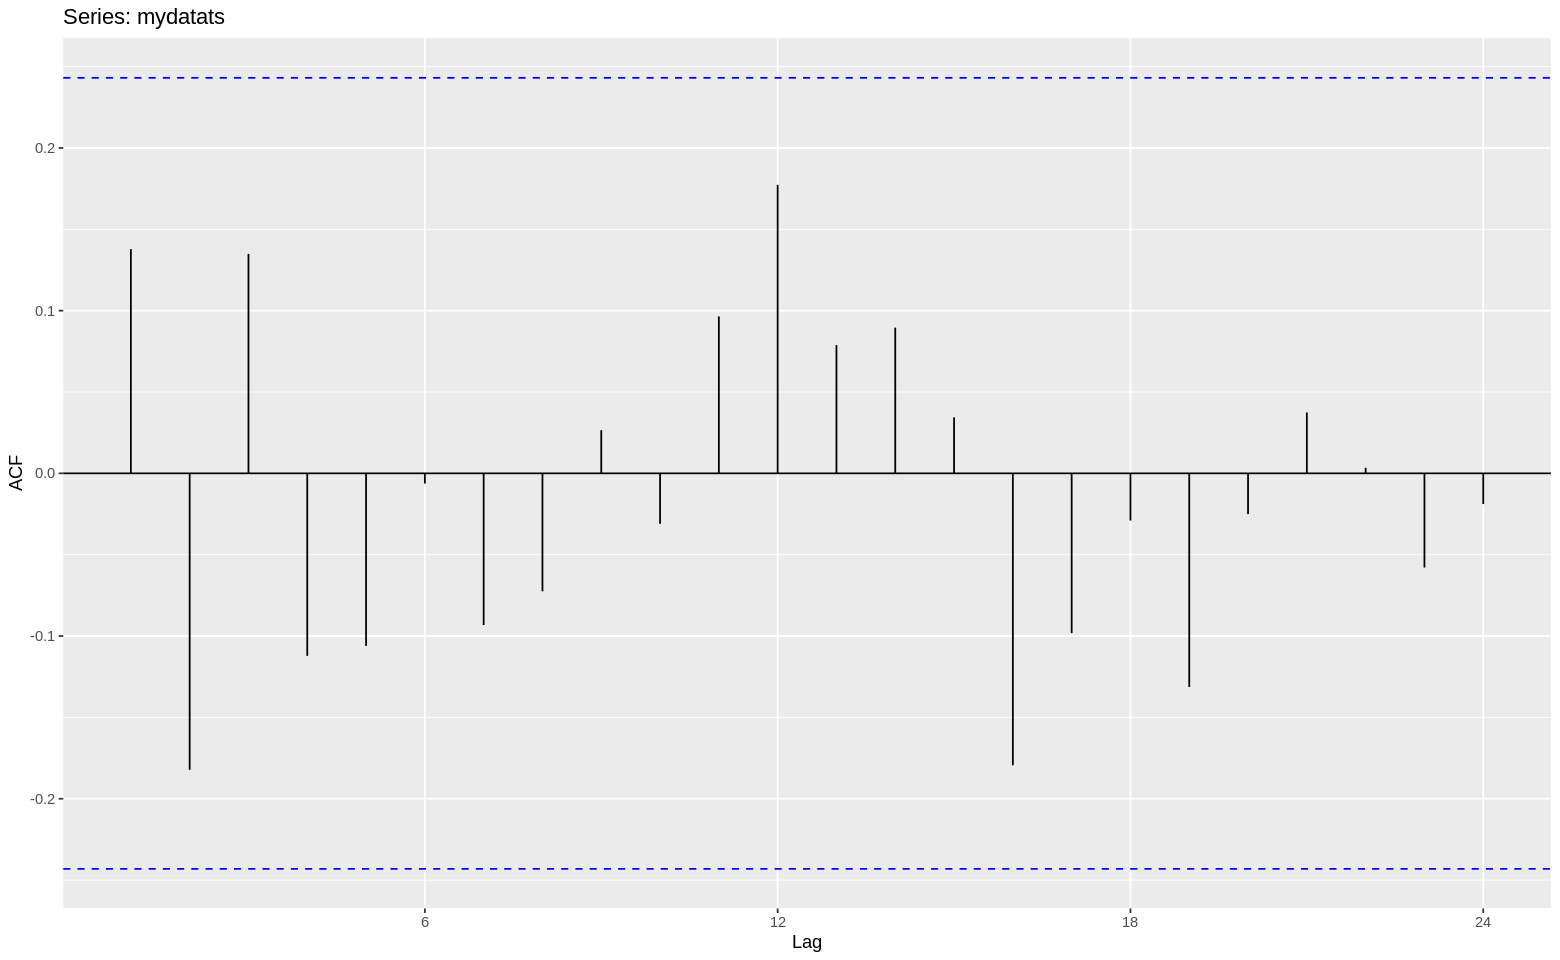

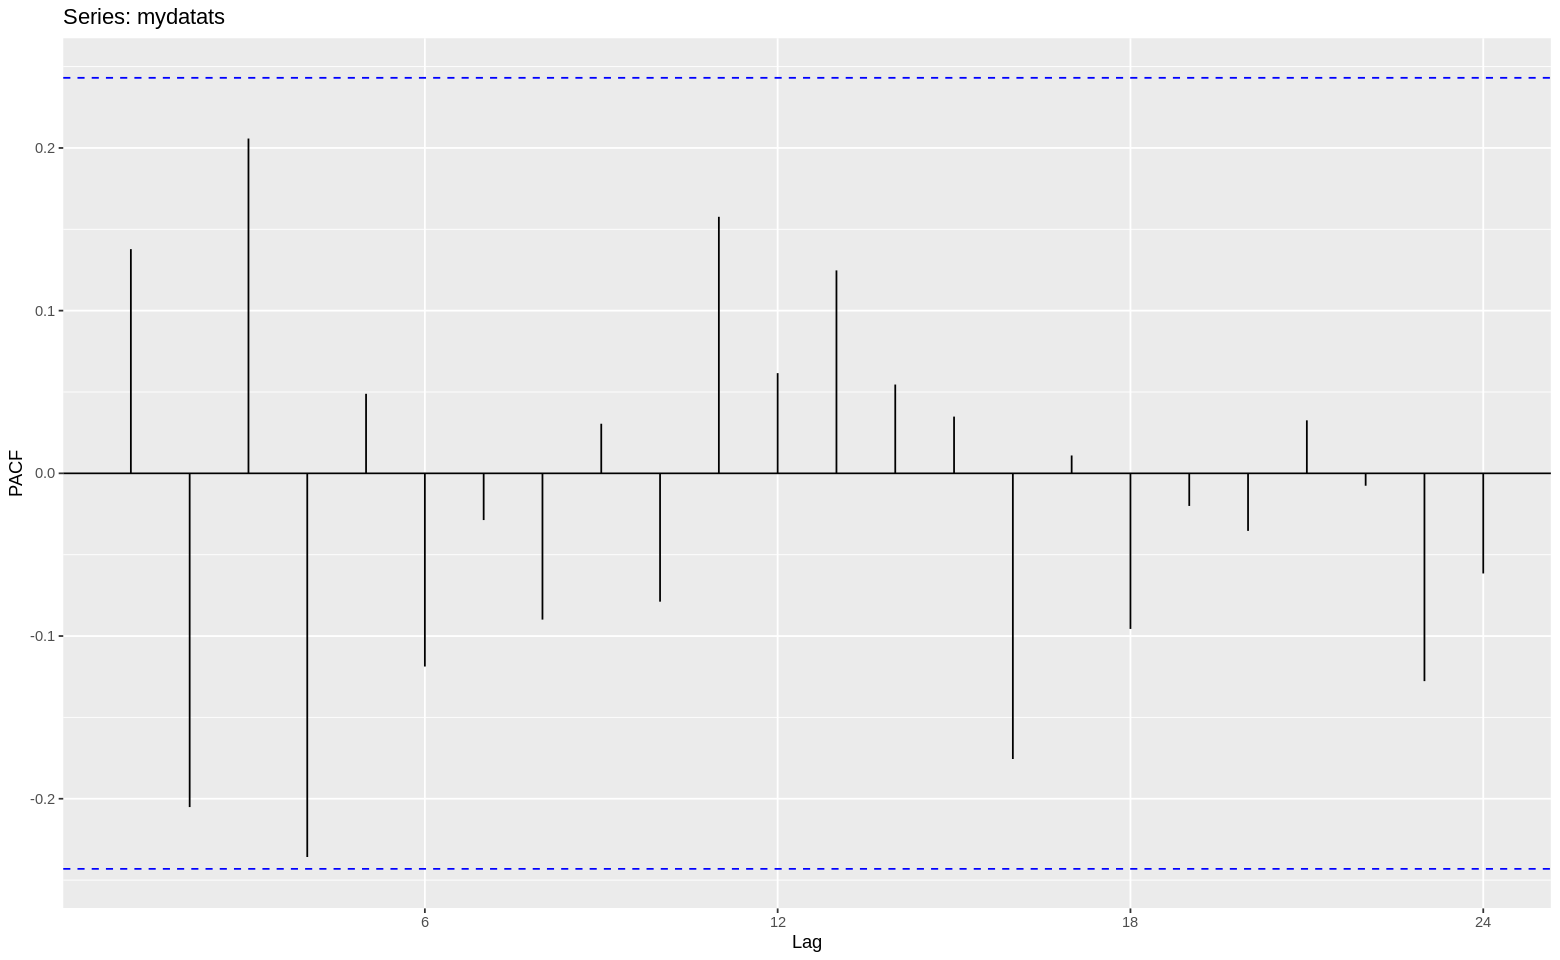

In [77]:
ggAcf(mydatats)
ggPacf(mydatats)

In [78]:
fit %>% forecast(h=10) ##%>% autoplot(include=80)

         Point Forecast       Lo 80    Hi 80     Lo 95    Hi 95
Jun 2023      24.982137  -0.8179577 50.78223 -14.47570 64.43998
Jul 2023       6.620261 -21.3182985 34.55882 -36.10808 49.34860
Aug 2023      13.120810 -17.3509067 43.59253 -33.48166 59.72328
Sep 2023      13.120810 -17.3509067 43.59253 -33.48166 59.72328
Oct 2023      13.120810 -17.3509067 43.59253 -33.48166 59.72328
Nov 2023      13.120810 -17.3509067 43.59253 -33.48166 59.72328
Dec 2023      13.120810 -17.3509067 43.59253 -33.48166 59.72328
Jan 2024      13.120810 -17.3509067 43.59253 -33.48166 59.72328
Feb 2024      13.120810 -17.3509067 43.59253 -33.48166 59.72328
Mar 2024      13.120810 -17.3509067 43.59253 -33.48166 59.72328

`geom_smooth()` using formula = 'y ~ x'


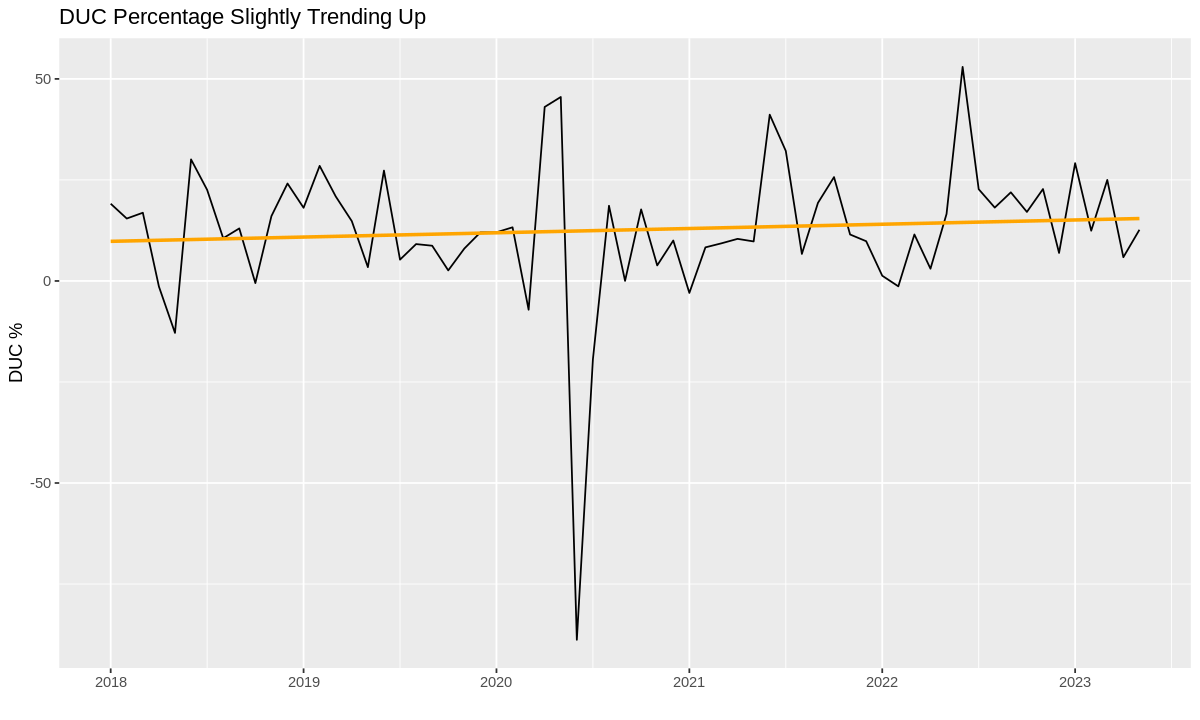

In [81]:
#Seasonal adjustment
mydatats %>% stl(t.window = 13, s.window='periodic') %>% seasadj() -> eeadj

# Plot the time series
options(repr.plot.width = 10, repr.plot.height = 6)
autoplot(eeadj) +   geom_smooth(method = "lm", se = FALSE, color = "orange") +   labs(title = "DUC Percentage Slightly Trending Up", x = "", y = "DUC %")

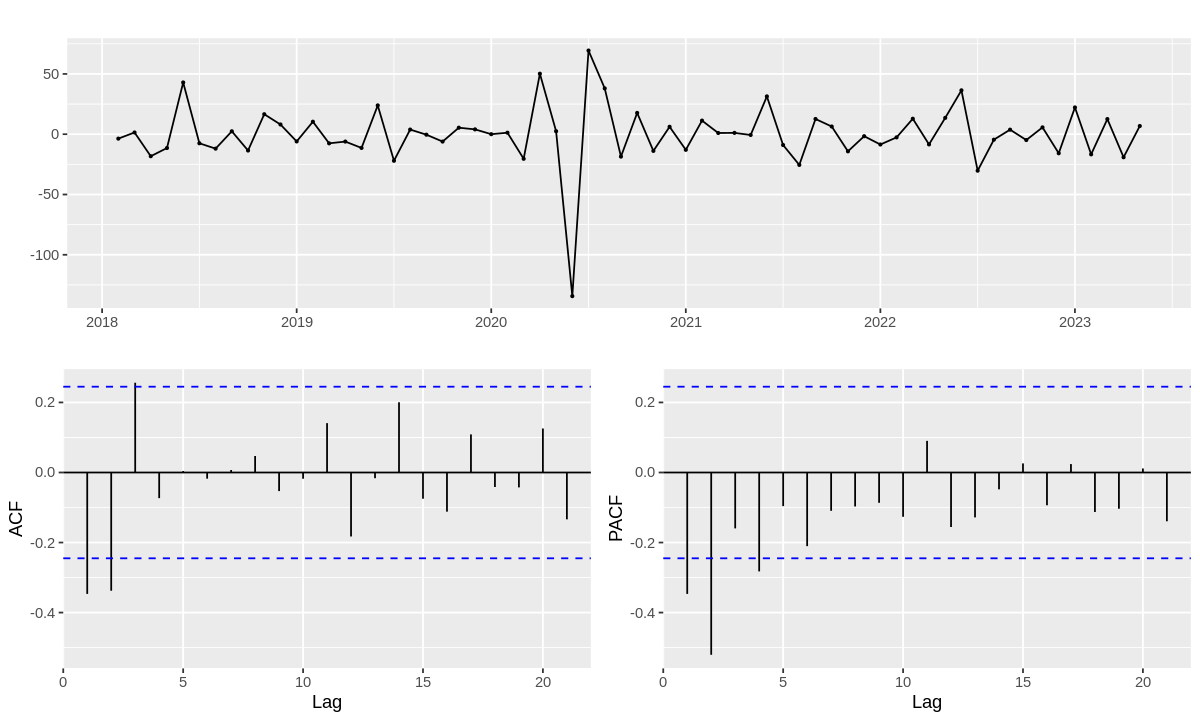

In [82]:
# No change in variance so no Box-Cox transformation,
# But not stationary so we neeed to difference
# ACF is suggestive of an MA(3) PACF suggests AR(4)
eeadj %>% diff() %>% ggtsdisplay(main="")

In [83]:
(fit2 <- Arima(eeadj, order=c(4,1,3)))

Series: eeadj 
ARIMA(4,1,3) 

Coefficients:
         ar1     ar2     ar3     ar4      ma1      ma2     ma3
      0.0492  0.4598  0.1010  0.0954  -0.8357  -0.9211  0.7568
s.e.  0.4498  0.3277  0.1433  0.1418   0.4336   0.1533  0.3931

sigma^2 = 318.7:  log likelihood = -273.9
AIC=563.81   AICc=566.43   BIC=581.08


	Ljung-Box test

data:  Residuals from ARIMA(4,1,3)
Q* = 1.4315, df = 6, p-value = 0.9639

Model df: 7.   Total lags used: 13



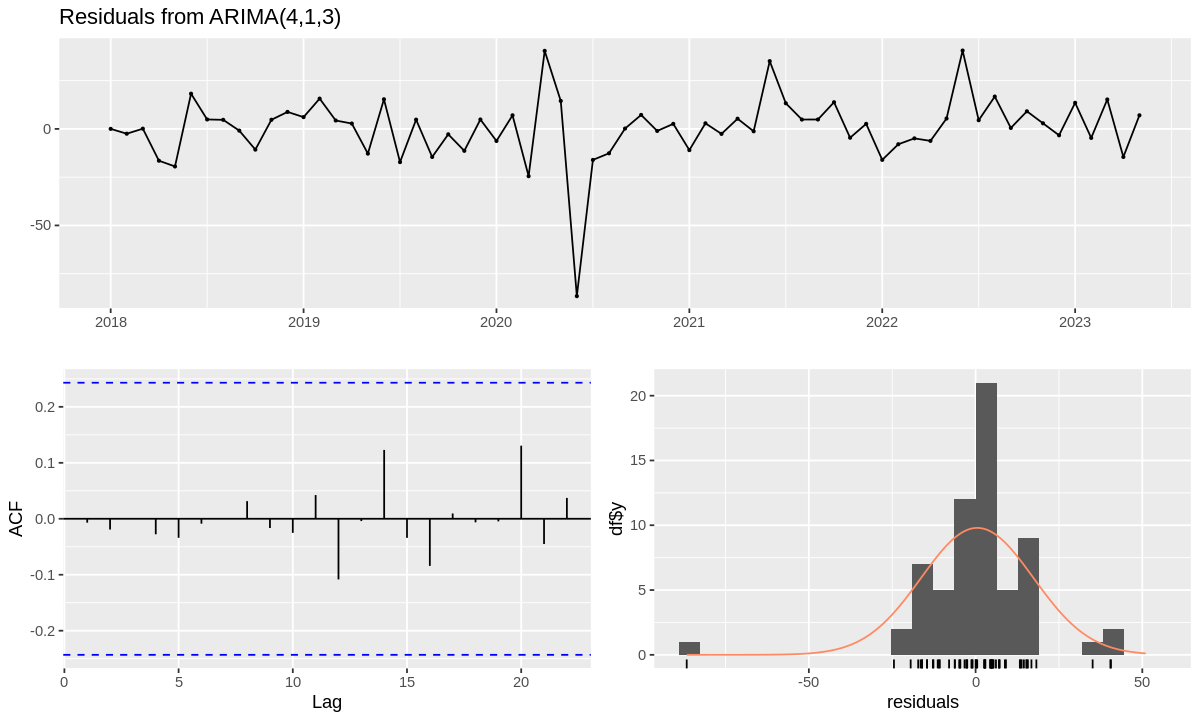

In [85]:
# ACF plot of the residuals from the ARIMA(4,1,3) model shows that all autocorrelations are within the threshold limits,indicating that the residuals are behaving like white noise.
# A portmanteau test returns a large p-value, also suggesting that the residuals are white noise
checkresiduals(fit2)

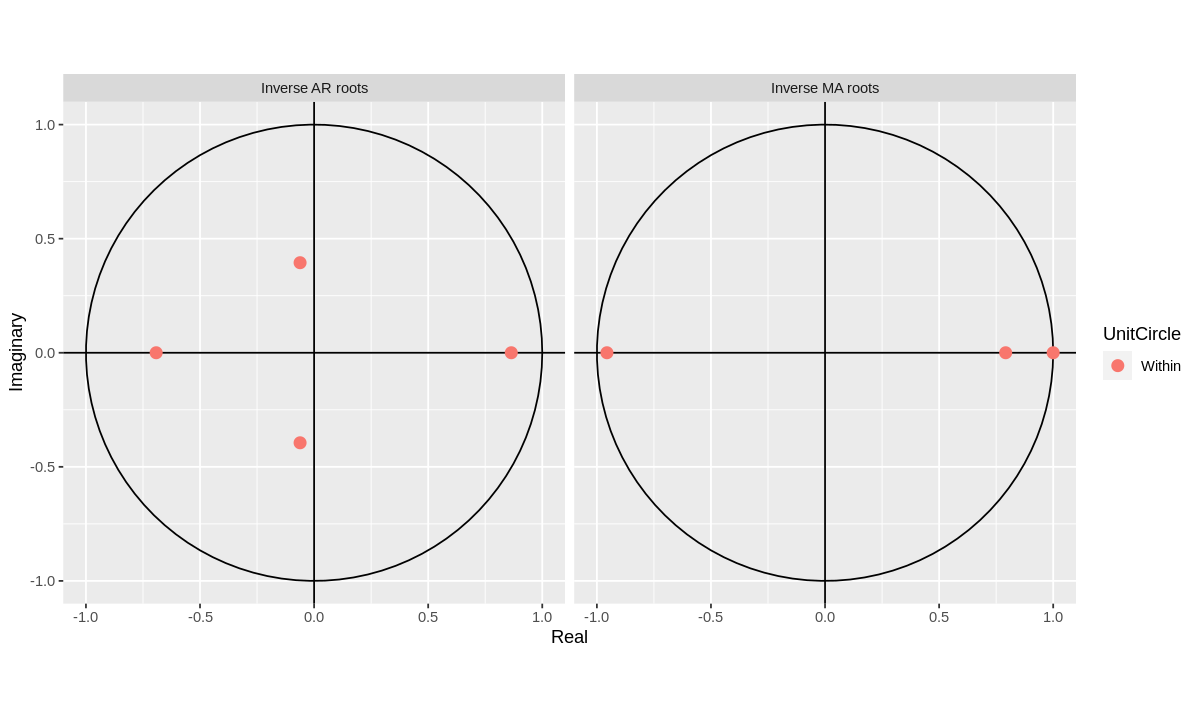

In [86]:
#They are all inside the unit circle, as we would expect because R ensures the fitted model is both stationary and invertible.
autoplot(fit2)

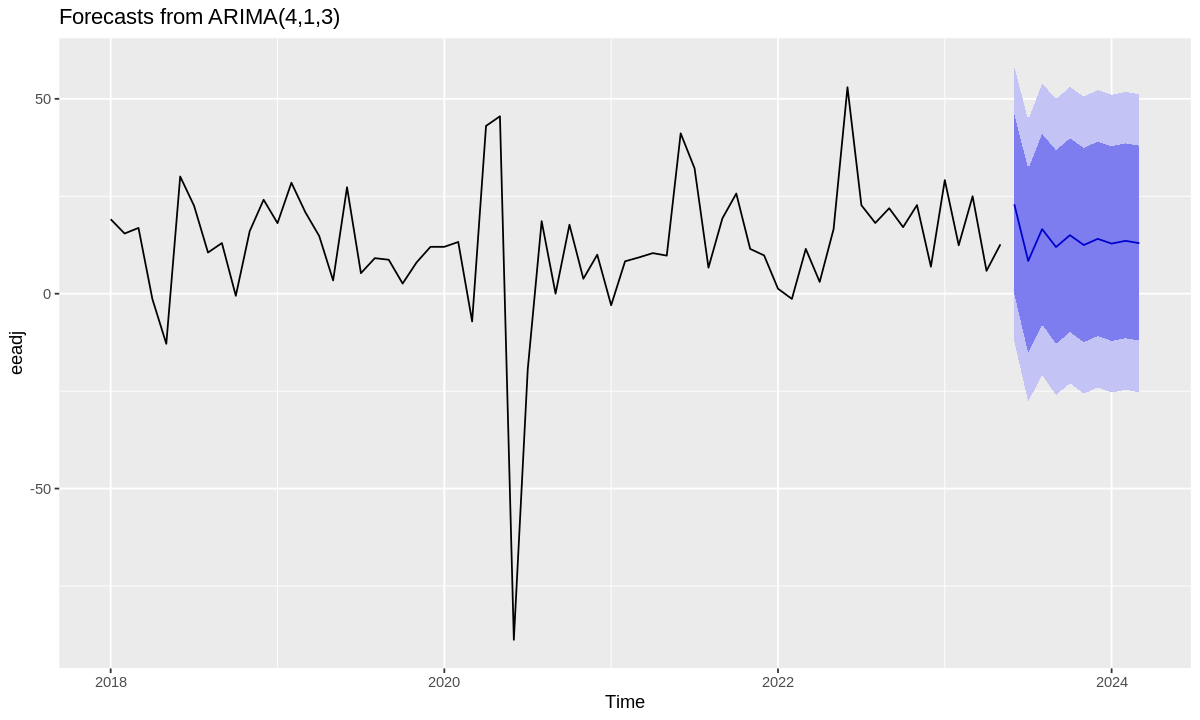

In [89]:
fit2 %>% forecast(h=10) %>% autoplot()

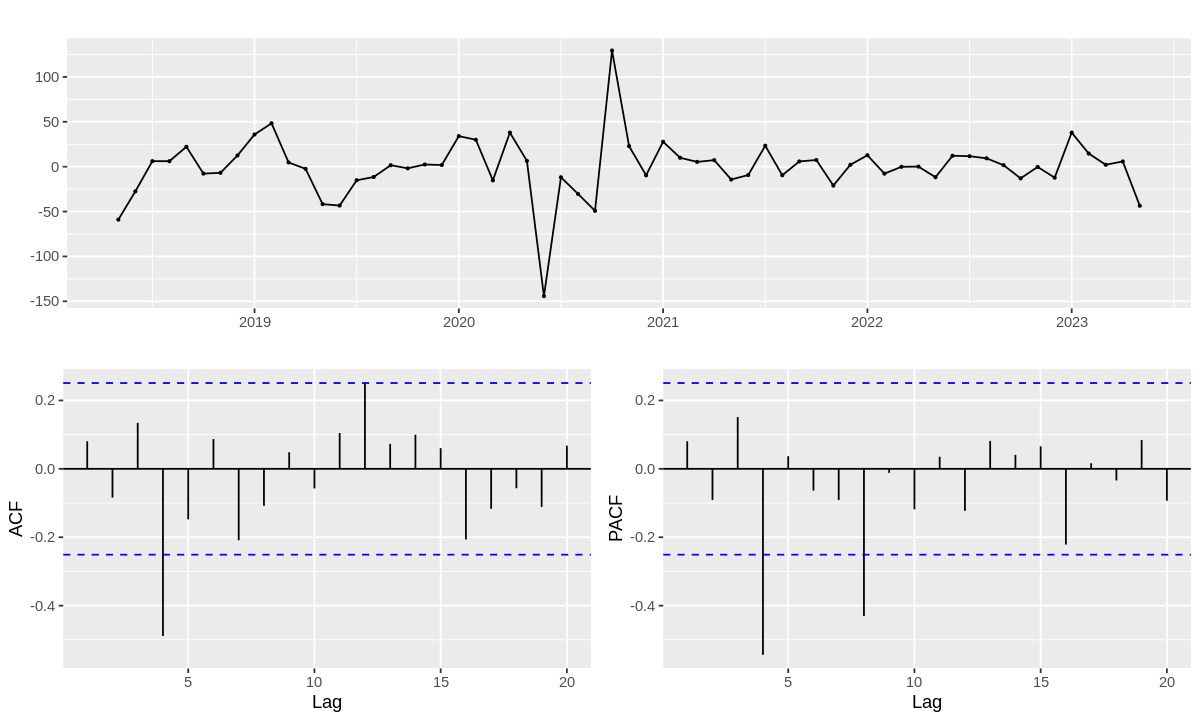

In [93]:
# taking a seasonal difference
# MA(4) AR(8) ?


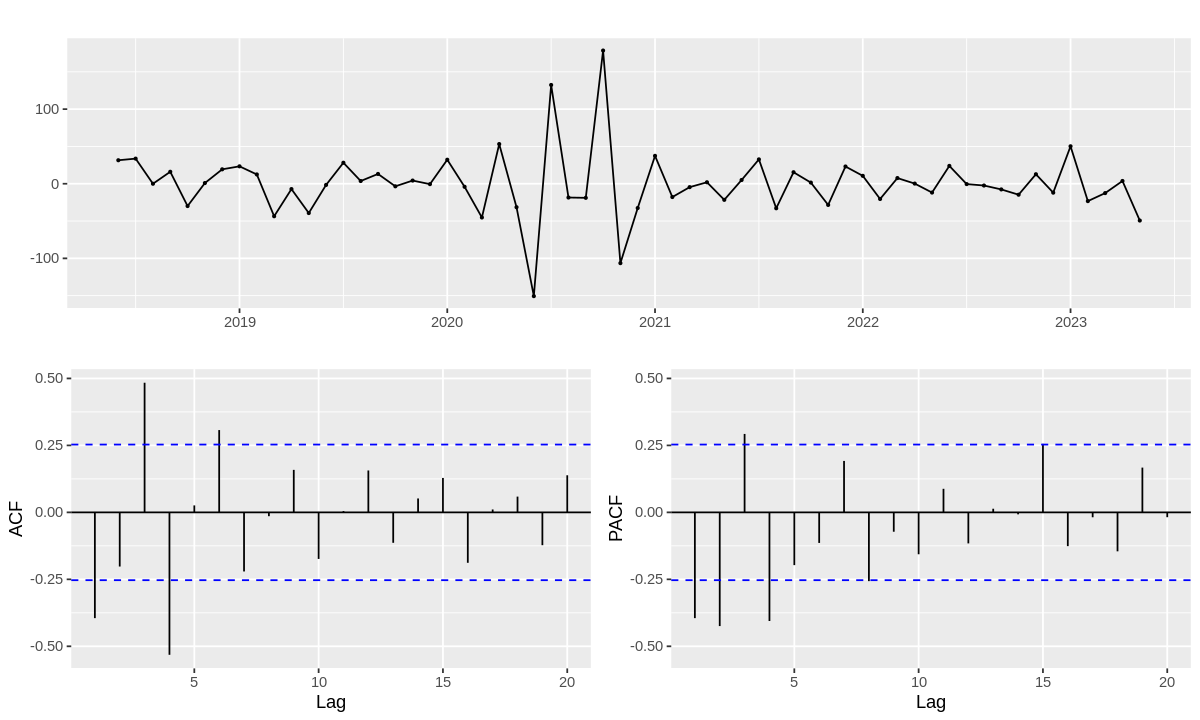

In [94]:
#These also appear to be non-stationary, so we take an additional first difference
# The significant spike at lag 3 in the ACF suggests a non-seasonal MA(3) component, and the significant spike at lag 4 in the ACF suggests a seasonal MA(1) component.
#The significant spike at lag 3 in the PACF suggests a non-seasonal MA(3) component, and the significant spike at lag 4 in the PACF suggests a seasonal MA(1) component.
 mydatats %>% diff(lag=4) %>% diff()  %>% ggtsdisplay()

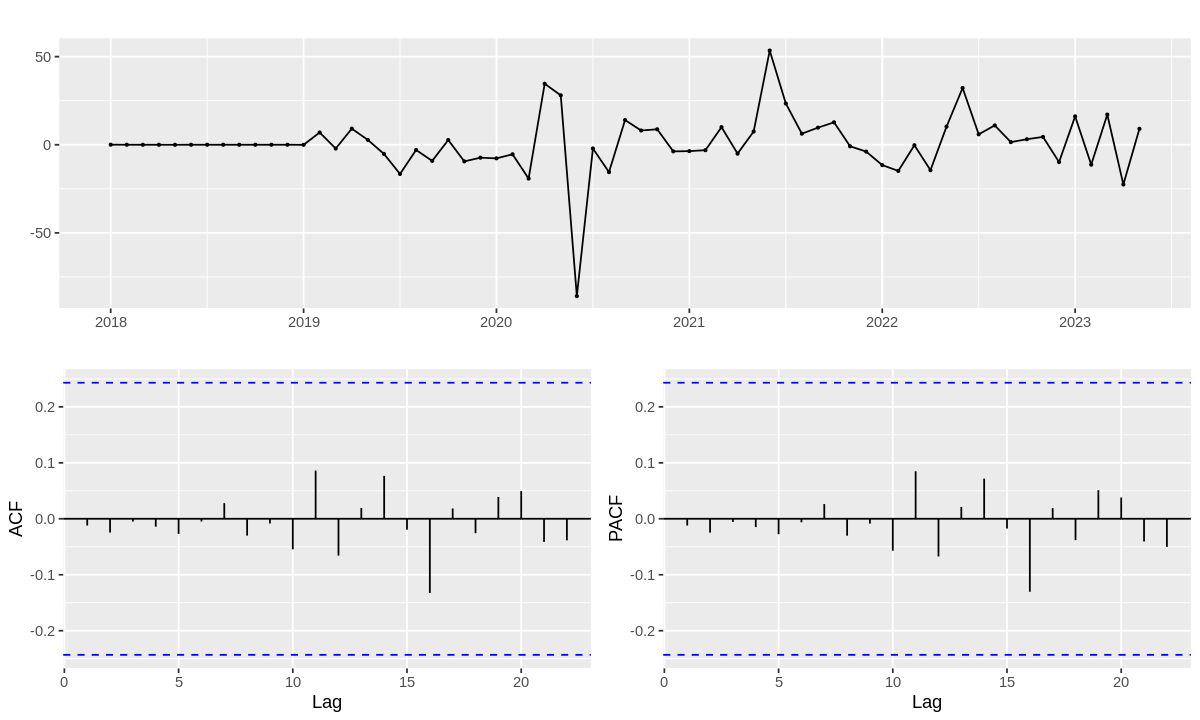

In [95]:
 #ARIMA(3,1,3)(1,1,1) model indicates a seasonal difference, and non-seasonal and seasonal AR() an MA() components
 mydatats %>%
  Arima(order=c(3,1,3), seasonal=c(1,1,1)) %>%
  residuals() %>% ggtsdisplay()

In [96]:
(fit3 <- Arima(eeadj, order=c(4,1,3), seasonal=c(1,1,1)))

Warning message in sqrt(diag(x$var.coef)):
“NaNs produced”


Series: eeadj 
ARIMA(4,1,3)(1,1,1)[12] 

Coefficients:
          ar1      ar2      ar3     ar4      ma1      ma2     ma3    sar1
      -0.5515  -0.0619  -0.0328  0.0084  -0.1428  -0.9288  0.2138  0.1042
s.e.      NaN      NaN      NaN     NaN      NaN      NaN     NaN  0.1729
         sma1
      -0.9998
s.e.   0.2654

sigma^2 = 425.7:  log likelihood = -238.4
AIC=496.79   AICc=502.16   BIC=516.3


	Ljung-Box test

data:  Residuals from ARIMA(4,1,3)(1,1,1)[12]
Q* = 1.4648, df = 4, p-value = 0.8329

Model df: 9.   Total lags used: 13



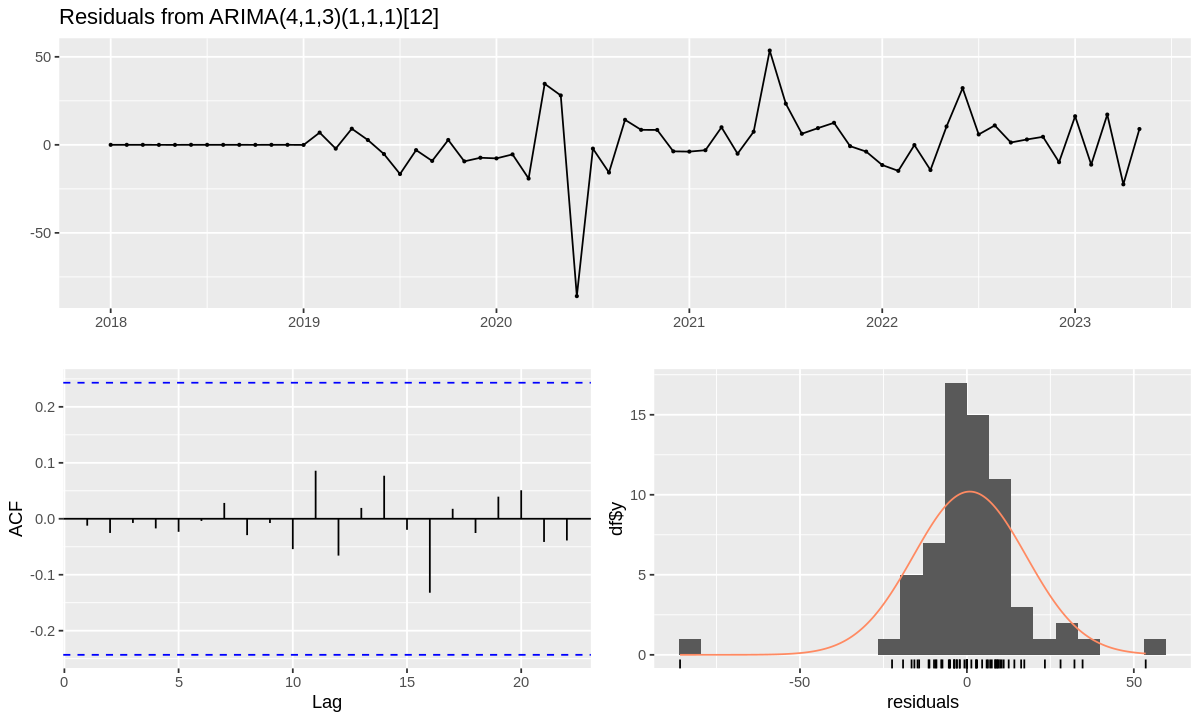

In [99]:
# ACF plot of the residuals from the ARIMA(4,1,3) , seasonal=c(1,1,1) model shows that all autocorrelations are within the threshold limits,indicating that the residuals are behaving like white noise.
# A portmanteau test returns a large p-value, also suggesting that the residuals are white noise. Above AIC is the smallest
checkresiduals(fit3)

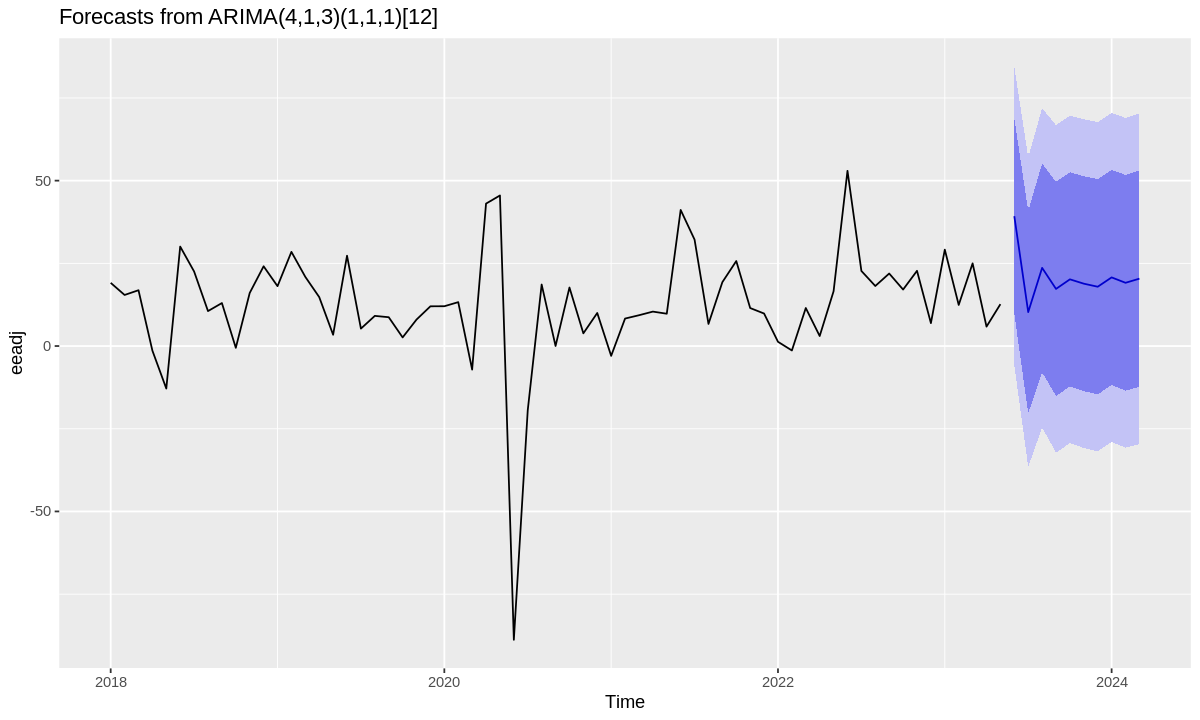

In [100]:
fit3 %>% forecast(h=10) %>% autoplot()

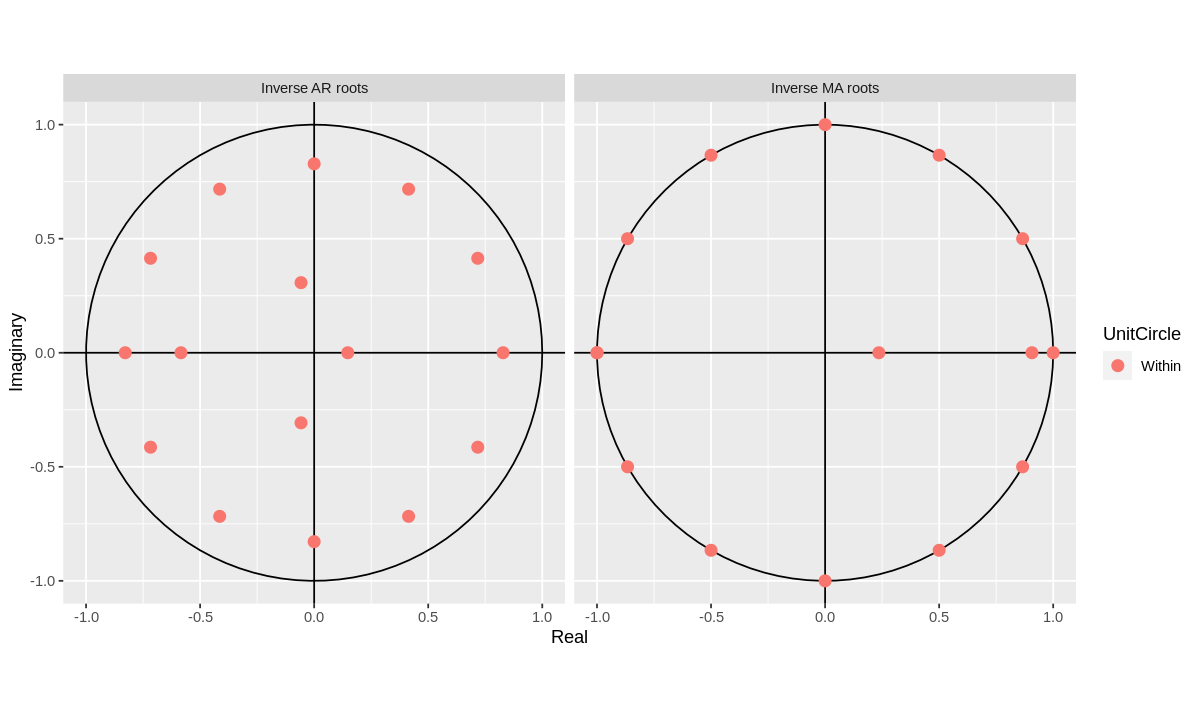

In [101]:
#They are all inside the unit circle, as we would expect because R ensures the fitted model is both stationary and invertible.
autoplot(fit3)